## Motivation
Currently AI is advancing in the field of healthcare to improve detection of malignant tumors, give treatment recommendations, engage patients and support in administrative activities (Davenport and Kalakota 2019). Our goal is to contribute to this field by applying a neural network with transfer learning on a dataset with the aim to detect malignant cells of breast cancer. 

According to Krebsliga Schweiz (2021), there are 6’250 new cases and 1’410 deaths associated with breast cancer in Switzerland every year. Early diagnosis and treatment are a key to increasing the 5-year survival rate of patients.  

From a technical standpoint we want to investigate the performance differences between neural networks with and without transfer learning in the field of tumor detection.

## Data

We use the Kaggle dataset: Breast Histopathology Images, which contains 277’524 images that are classified whether the sample is positive or negative for Invasive Ductal Carcinoma (IDC). Therefore, we face a binary classification problem with this dataset. The sample dataset contains images scanned at 40x zoom that are prepared in 50 x 50-pixel patches.

[Kaggle Dataset](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)

#### Import packages

In [3]:
import IPython
import pandas as pd
import numpy as np
import datetime
import pickle

# used to access folder structures
import os

# used to open images
import PIL

# Graphs, visualizations
import matplotlib.pyplot
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import scipy

# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
# For Image Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
# from tensorflow.keras import layers
from keras.optimizers import Adam, SGD


from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
# Check for gpu support
# Troubleshooting: 
# Python Version = 3.7.9
# tensorflow Version = 2.3.0
# tf.keras Version = 2.4.0

# from platform import python_version
# print(python_version())
# print(tf.__version__)
# print(tf.keras.__version__)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Import Data From Pickle file

with open('y.pickle', 'rb') as f:
    y_data = pickle.load(f)
f.close()
y_data

with open('X.pickle', 'rb') as f:
    X_data = pickle.load(f)
f.close()
type(X_data)

UnpicklingError: pickle data was truncated

### Learnings
* The data of positive and negative samples is unbalanced, where patients have more negative patches than positive ones
* This could lead to an imbalanced result where we classify more patches as negative, which would be a severe mistake in cancer detection. A confusion matrix should be sufficient so verify this concern, when the model is trained

In [7]:
#Train-validation-test split

x_train,x_test,y_train,y_test=train_test_split(np.asarray(X_data),np.asarray(y_data),test_size=.3, random_state=42)

#x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

#Dimension of the kaggle dataset
print((x_train.shape,y_train.shape))
#print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

input_shape=x_train.shape[1:]
input_shape

((194266, 50, 50, 3), (194266,))
((83258, 50, 50, 3), (83258,))


(50, 50, 3)

### Simple Neural Network 

As a first network we:
- Flatten the input from the images
- Use one hidden layer with 64 neurons and a sigmoid activation function
- Use one sigmoid activation function for the ouput layer

In [9]:
batch_size = 4096
epochs = 100

name="Simple-1-layer-network"
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='sigmoid'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.0001), metrics=["accuracy"])

history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/100
43/43 [==============================] - 1s 16ms/step - loss: 0.6012 - accuracy: 0.7157 - val_loss: 0.5912 - val_accuracy: 0.7167
Epoch 2/100
43/43 [==============================] - 1s 14ms/step - loss: 0.5851 - accuracy: 0.7157 - val_loss: 0.5780 - val_accuracy: 0.7167
Epoch 3/100
43/43 [==============================] - 1s 13ms/step - loss: 0.5776 - accuracy: 0.7157 - val_loss: 0.5750 - val_accuracy: 0.7167
Epoch 4/100
43/43 [==============================] - 1s 14ms/step - loss: 0.5757 - accuracy: 0.7157 - val_loss: 0.5732 - val_accuracy: 0.7167
Epoch 5/100
43/43 [==============================] - 1s 13ms/step - loss: 0.5743 - accuracy: 0.7157 - val_loss: 0.5719 - val_accuracy: 0.7167
Epoch 6/100
43/43 [==============================] - 1s 14ms/step - loss: 0.5733 - accuracy: 0.7157 - val_loss: 0.5709 - val_accuracy: 0.7167
Epoch 7/100
43/43 [==============================] - 1s 13ms/step - loss: 0.5724 - accuracy: 0.7157 - val_loss: 0.5702 - val_accuracy: 0.7167
Epoch 

Epoch 58/100
43/43 [==============================] - 1s 14ms/step - loss: 0.5365 - accuracy: 0.7158 - val_loss: 0.5349 - val_accuracy: 0.7168
Epoch 59/100
43/43 [==============================] - 1s 14ms/step - loss: 0.5361 - accuracy: 0.7158 - val_loss: 0.5344 - val_accuracy: 0.7168
Epoch 60/100
43/43 [==============================] - 1s 14ms/step - loss: 0.5356 - accuracy: 0.7158 - val_loss: 0.5340 - val_accuracy: 0.7168
Epoch 61/100
43/43 [==============================] - 1s 13ms/step - loss: 0.5352 - accuracy: 0.7158 - val_loss: 0.5339 - val_accuracy: 0.7168
Epoch 62/100
43/43 [==============================] - 1s 14ms/step - loss: 0.5348 - accuracy: 0.7158 - val_loss: 0.5332 - val_accuracy: 0.7168
Epoch 63/100
43/43 [==============================] - 1s 14ms/step - loss: 0.5344 - accuracy: 0.7158 - val_loss: 0.5328 - val_accuracy: 0.7168
Epoch 64/100
43/43 [==============================] - 1s 14ms/step - loss: 0.5340 - accuracy: 0.7158 - val_loss: 0.5324 - val_accuracy: 0.7168

Model: "Simple-1-layer-network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                480064    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 480,129
Trainable params: 480,129
Non-trainable params: 0
_________________________________________________________________


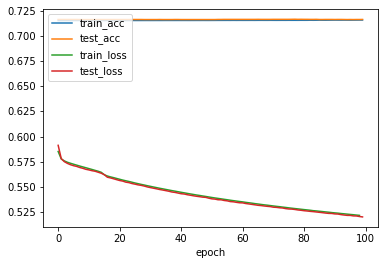

In [10]:
model.summary()
# list all data in history
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['train_acc', 'test_acc', 'train_loss', 'test_loss'], loc='upper left')
plt.show()

In [11]:
batch_size = 2048
epochs = 200

name="Simple-1-layer-network"
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.0001), metrics=["accuracy"])

history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/100
86/86 [==============================] - 1s 9ms/step - loss: 22.3572 - accuracy: 0.6932 - val_loss: 0.5665 - val_accuracy: 0.7160
Epoch 2/100
86/86 [==============================] - 1s 8ms/step - loss: 0.5641 - accuracy: 0.7149 - val_loss: 0.5574 - val_accuracy: 0.7166
Epoch 3/100
86/86 [==============================] - 1s 8ms/step - loss: 0.5559 - accuracy: 0.7161 - val_loss: 0.5502 - val_accuracy: 0.7208
Epoch 4/100
86/86 [==============================] - 1s 8ms/step - loss: 0.5472 - accuracy: 0.7210 - val_loss: 0.5402 - val_accuracy: 0.7266
Epoch 5/100
86/86 [==============================] - 1s 8ms/step - loss: 0.5373 - accuracy: 0.7286 - val_loss: 0.5303 - val_accuracy: 0.7349
Epoch 6/100
86/86 [==============================] - 1s 8ms/step - loss: 0.5280 - accuracy: 0.7374 - val_loss: 0.5254 - val_accuracy: 0.7374
Epoch 7/100
86/86 [==============================] - 1s 8ms/step - loss: 0.5201 - accuracy: 0.7448 - val_loss: 0.5147 - val_accuracy: 0.7473
Epoch 8/100


Epoch 59/100
86/86 [==============================] - 1s 8ms/step - loss: 0.4552 - accuracy: 0.7953 - val_loss: 0.4525 - val_accuracy: 0.7973
Epoch 60/100
86/86 [==============================] - 1s 8ms/step - loss: 0.4549 - accuracy: 0.7959 - val_loss: 0.4522 - val_accuracy: 0.7979
Epoch 61/100
86/86 [==============================] - 1s 8ms/step - loss: 0.4547 - accuracy: 0.7962 - val_loss: 0.4523 - val_accuracy: 0.7983
Epoch 62/100
86/86 [==============================] - 1s 8ms/step - loss: 0.4544 - accuracy: 0.7960 - val_loss: 0.4521 - val_accuracy: 0.7982
Epoch 63/100
86/86 [==============================] - 1s 8ms/step - loss: 0.4543 - accuracy: 0.7960 - val_loss: 0.4515 - val_accuracy: 0.7985
Epoch 64/100
86/86 [==============================] - 1s 8ms/step - loss: 0.4540 - accuracy: 0.7961 - val_loss: 0.4523 - val_accuracy: 0.7972
Epoch 65/100
86/86 [==============================] - 1s 8ms/step - loss: 0.4537 - accuracy: 0.7964 - val_loss: 0.4512 - val_accuracy: 0.7985
Epoch 

Model: "Simple-1-layer-network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               960128    
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_19 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dense_20 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)    

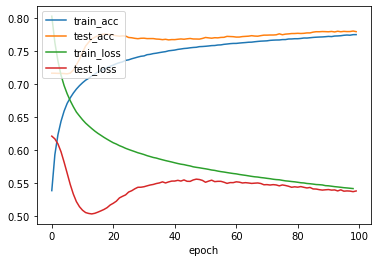

In [36]:
model.summary()
# list all data in history
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['train_acc', 'test_acc', 'train_loss', 'test_loss'], loc='upper left')
plt.show()

In [15]:
#Image Data Augmentation

train_generator = ImageDataGenerator(rotation_range=20, horizontal_flip=True, vertical_flip=True)

val_generator = ImageDataGenerator(rotation_range=20, horizontal_flip=True, vertical_flip=True)

train_generator.fit(x_train)
val_generator.fit(x_val)

In [41]:
batch_size = 16384
epochs = 200

name="Simple-1-layer-network"
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/200
11/11 [==============================] - 2s 216ms/step - loss: 0.7357 - accuracy: 0.7014 - val_loss: 10.2920 - val_accuracy: 0.7167
Epoch 2/200
11/11 [==============================] - 2s 200ms/step - loss: 0.6318 - accuracy: 0.7371 - val_loss: 2.3982 - val_accuracy: 0.7166
Epoch 3/200
11/11 [==============================] - 2s 199ms/step - loss: 0.6038 - accuracy: 0.7540 - val_loss: 1.6146 - val_accuracy: 0.7166
Epoch 4/200
11/11 [==============================] - 2s 199ms/step - loss: 0.5803 - accuracy: 0.7676 - val_loss: 1.2276 - val_accuracy: 0.7165
Epoch 5/200
11/11 [==============================] - 2s 199ms/step - loss: 0.5647 - accuracy: 0.7744 - val_loss: 0.9308 - val_accuracy: 0.7157
Epoch 6/200
11/11 [==============================] - 2s 199ms/step - loss: 0.5496 - accuracy: 0.7832 - val_loss: 0.6944 - val_accuracy: 0.7038
Epoch 7/200
11/11 [==============================] - 2s 199ms/step - loss: 0.5367 - accuracy: 0.7919 - val_loss: 0.7798 - val_accuracy: 0.623

Epoch 114/200
11/11 [==============================] - 2s 200ms/step - loss: 0.2821 - accuracy: 0.8864 - val_loss: 0.5685 - val_accuracy: 0.7704
Epoch 115/200
11/11 [==============================] - 2s 201ms/step - loss: 0.2796 - accuracy: 0.8869 - val_loss: 0.5197 - val_accuracy: 0.7712
Epoch 116/200
11/11 [==============================] - 2s 202ms/step - loss: 0.2795 - accuracy: 0.8871 - val_loss: 0.4264 - val_accuracy: 0.8033
Epoch 117/200
11/11 [==============================] - 2s 201ms/step - loss: 0.2782 - accuracy: 0.8879 - val_loss: 0.6531 - val_accuracy: 0.7538
Epoch 118/200
11/11 [==============================] - 2s 201ms/step - loss: 0.2756 - accuracy: 0.8891 - val_loss: 0.6183 - val_accuracy: 0.7827
Epoch 119/200
11/11 [==============================] - 2s 202ms/step - loss: 0.2757 - accuracy: 0.8888 - val_loss: 0.5958 - val_accuracy: 0.7733
Epoch 120/200
11/11 [==============================] - 2s 200ms/step - loss: 0.2734 - accuracy: 0.8903 - val_loss: 0.5568 - val_ac

Model: "Simple-1-layer-network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 7500)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 2048)              15362048  
_________________________________________________________________
batch_normalization_14 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_15 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)   

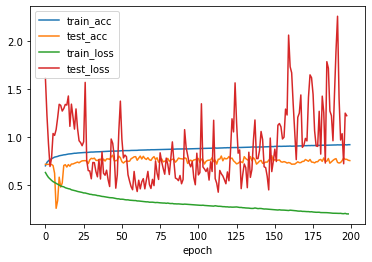

In [42]:
model.summary()
# list all data in history
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][2:])
plt.xlabel('epoch')
plt.legend(['train_acc', 'test_acc', 'train_loss', 'test_loss'], loc='upper left')
plt.show()

In [ ]:
#Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.1,
                       patience=3,
                       min_lr=1e-8,
                       verbose=2)


#Early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=2,
                                      mode='auto', baseline=None, restore_best_weights=True)

In [ ]:
name="5x5ConvX2-3x3ConvX2_512DenseWith0.2DropoutX2"
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        
        layers.Conv2D(64,kernel_size=(5,5),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64,kernel_size=(5,5),activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        
        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Flatten(),
        layers.Dense(1024,activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1024,activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(1, activation='sigmoid')    
    
    ],name=name
)

In [ ]:
model.summary()

In [ ]:
batch_size = 128
epochs = 50

model.compile(loss="binary_crossentropy", optimizer=Adam(epsilon=1e-07, learning_rate=0.001), metrics=["accuracy"])

history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,callbacks=[es, lrr])

# Transfer learning

## Simple Transfer learning

In [7]:
input_shape = (50, 50, 3)
model_input = keras.Input(shape=input_shape)
beforeModel = keras.layers.UpSampling2D()(model_input)

# load pretrained resnet, don't train resnet
print(beforeModel)
resnet = keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(200,200,3))
resnet.trainable=False
x = resnet(beforeModel,training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024,
                       kernel_regularizer=l2(0.001),
                       bias_regularizer=l2(0.001),
                       activation='relu')(x) # dense layer 1 
output = keras.layers.Dense(units=1, activation='sigmoid')(x)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), name='up_sampling2d_1/resize/ResizeNearestNeighbor:0', description="created by layer 'up_sampling2d_1'")
94773248/94765736 [==============================] - 22s 0us/step


In [8]:
model = keras.Model(inputs = model_input, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 100, 100, 3)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 200, 200, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 1024)              102761

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=Adam(epsilon=0.1, learning_rate=0.001), metrics=["accuracy"])
log_dir= os.path.join('logs','ResNet50',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),'')

# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history=model.fit(train_generator.flow(x_train, y_train),
                  batch_size=batch_size, epochs=epochs,
                  validation_data=val_generator.flow(x_val, y_val),
                  callbacks=[es, lrr]) 

## Advanced transfer learning

We hope to improve the performance of the transfer learning model by adding more layers before and after the pretrained resnet.
The intuition is that by adding layers we increase the capacity of the model to fit more complex functions. Besides that we add regularization layers like Dropout and BatchNormalization.

In [ ]:
model_input = tf.keras.Input(shape=input_shape)
beforeModel = tf.keras.layers.UpSampling2D()(model_input)
beforeModel = tf.keras.layers.UpSampling2D()(beforeModel)
beforeModel = tf.keras.layers.UpSampling2D()(beforeModel)
print(beforeModel)
resnet = tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(200,200,3))
resnet.trainable=False
x = resnet(beforeModel,training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024,
                       kernel_regularizer=l2(0.001),
                       bias_regularizer=l2(0.001),
                       activation='relu')(x) # dense layer 1 

x = keras.layers.Dropout(0.3)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024,
                       activation='relu',
                       kernel_regularizer=l2(0.001),
                       bias_regularizer=l2(0.001))(x) # dense layer 2
x = keras.layers.Dropout(0.2)(x) 

output = keras.layers.Dense(units=1, activation='sigmoid')(x)

In [ ]:
model = keras.Model(inputs = model_input, outputs = output)
model.summary()

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=Adam(epsilon=0.1, learning_rate=0.001), metrics=["accuracy"])
log_dir= os.path.join('logs','ResNet50',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),'')

# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history=model.fit(train_generator.flow(x_train, y_train),
                  batch_size=batch_size, epochs=epochs,
                  validation_data=val_generator.flow(x_val, y_val),
                  callbacks=[es, lrr]) 

## Transfer Learning: Experimenting with Hyperparameters

In [ ]:
learning_rates = [0.1, 0.01, 0.0001]